In [2]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
from scipy.signal import find_peaks

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

dx: 0.8682235195996664 cm
nx 1200


Text(0, 0.5, 'z (m)')

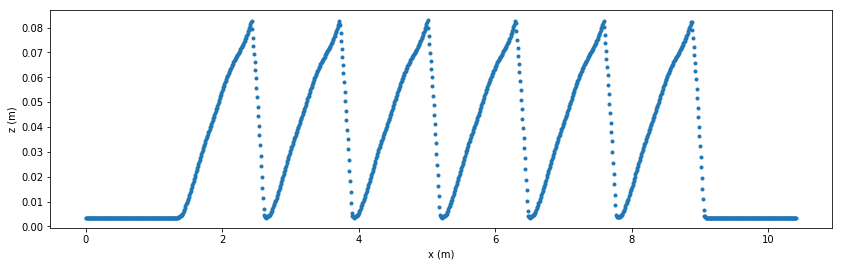

In [3]:
filepath = 'dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [4]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

In [177]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*5       # Runtime in seconds
dt = 2                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1

In [154]:
run_name = 'dune_5_q_{0}_h_{1}_static_reattachment'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
model.set_scale_factor(0.5)
model.use_modifier()

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

 Starting simulation....
Number of time steps: 7.5 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.5755326631493554 - Elevation 0.34821575665997495
Courant number: 2387.878515433302


KeyboardInterrupt: 

In [87]:
np.save('_output/{0}_verts.npy'.format(run_name),verts)

verts32_10mm = np.load('_output/{0}_verts.npy'.format(run_name))

verts32_10mm.shape

(29, 1200, 6)

In [7]:
def calculate_wave_height( z):
    top_peaks, _ = find_peaks(z, height = z.mean()*1.1)
    bottom_peaks, _ = find_peaks(-1.*z, height = z.mean()*-0.8, distance = int(1.2/dx))

    ztop = [z[i] for i in top_peaks]
    zbottom = [z[i] for i in bottom_peaks]

    ztop = np.array(ztop)
    ztop = np.delete(ztop, ztop.argmin())
    
    zbottom = np.array(zbottom)
    zbottom = np.delete(zbottom, zbottom.argmax())
    

    return ztop.mean() - zbottom.mean()
                
            
    
def calculate_wave_length(z,dx):
    peaks, _ = find_peaks(-1.*z, height = z.mean()*-1., distance = int(1.2/dx))
    lengths = []
    last_peak = None
    for peak in peaks:
        if last_peak == None:
            last_peak = peak
        else:
            
            tmpLength = dx * (peak-last_peak)
            
            if tmpLength > 1.2:
                lengths.append(tmpLength)
                last_peak = peak
                
    lengths = np.array(lengths)
    #lengths = np.delete(lengths, lengths.argmin())
    return lengths
    
def calculate_wave_movement(last_peak_index, current_z):
    
    peaks, _ = find_peaks(-1.*current_z, height = current_z.mean()*-0.8, distance = int(1.2/dx))
    
    updated_peak = None
    for peak in peaks:
        if peak > last_peak_index:
            updated_peak = peak
            #print(peak, last_peak_index)
            break

    return updated_peak

def calculate_wave_speed(verts, dx, dt):
    last_peak_index = None
    velocities = []
    timesteps = []
    base_index = 2
    step_index = 4
    for t in range(0, (verts.shape[0]), step_index):
        current_z = verts[t,:,1]
        peaks, _  = find_peaks(-1.*current_z, height = -1*current_z.mean(), distance=100)
        if last_peak_index is not None:
            delta = calculate_wave_movement(last_peak_index, current_z)
            last_peak_index = peaks[base_index]
            velocities.append(delta*dx/(dt*step_index))
            timesteps.append( dt * t )
        last_peak_index = peaks[base_index]
    return velocities, timesteps

def plot_results(verts):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))

    heights = [calculate_wave_height(verts[t,:,1]) for t in range((verts.shape[0]))]
    times = [t*5. for t in range((verts.shape[0]))]

    ax1.plot(times, heights)
    ax1.set_xlabel('Time (mins)')
    ax1.set_ylabel('$\Delta$ (m)')
    x = verts[0,:,0]
    dx = x[1] - x [0]
    lengths = [calculate_wave_length(verts[t,:,1],dx).mean() for t in range((verts.shape[0]))]
    ax2.plot(times, lengths)
    ax2.set_xlabel('Time (mins)')
    ax2.set_ylabel('$\Lambda$ (m)')
    ax2.set_ylim([0, 3.0])

    for t in range(0, (verts.shape[0]),5):
        z = verts[t,:,1]
        h = verts[t,:,4]
        x = verts[t,:,0]
        timestep = t * 5.
        ax3.plot(x,z, label='{0} mins'.format(timestep))
        ax3.plot(x,z+h, 'b')

    ax3.legend()
    ax3.set_xlabel('x (m)')
    ax3.set_ylabel('z (m)')


    v, timesteps = calculate_wave_speed(verts, dx, 5)
    ax4.plot(timesteps,v)
    ax4.set_ylim([0, 0.5])

    ax4.set_xlabel('Time (mins)')
    ax4.set_ylabel('Dune migration rate (m/min)')

    f.subplots_adjust(hspace=0.3)
    
def make_animation(verts):
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure(figsize=(12, 3))
    ax = plt.axes() #xlim=(0, 10), ylim=(0, 0.1))

    x0 = verts[0,:,0]
    z0 = verts[0,:,1]

    plt.plot(x0,z0)
    line, = ax.plot([], [], lw=2)



    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        x = verts[i,:,0]
        y = verts[i,:,1]
        line.set_data(x, y)
        return line,
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=verts.shape[0], interval=80, blit=True)
    return anim

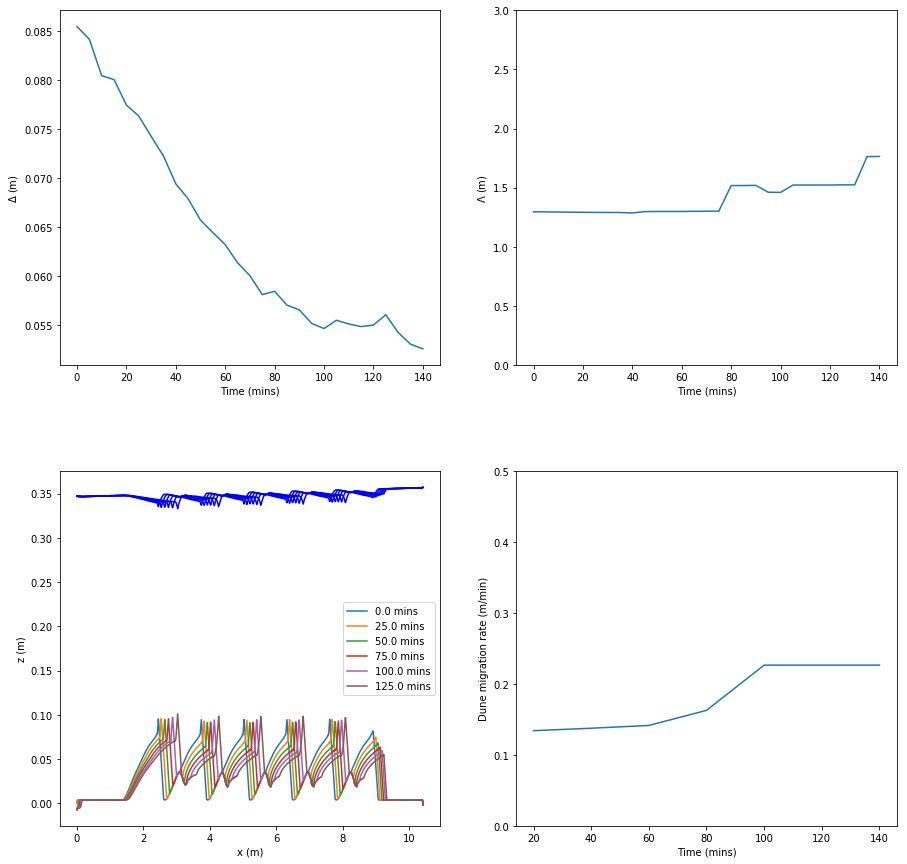

In [89]:
plot_results(verts32_10mm)

2019-05-25 18:23:43,982 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2019-05-25 18:23:43,983 INFO CLAW: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x216', '-pix_fmt', 'rgba', '-r', '12.5', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpqmdi2m9i/temp.m4v']


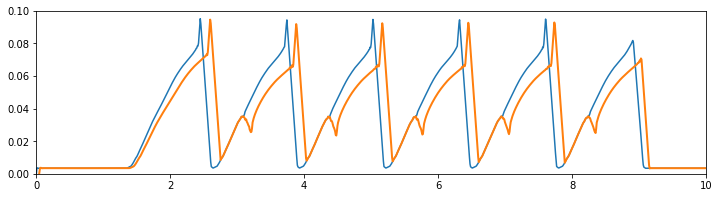

In [90]:
make_animation(verts32_10mm)

 Starting simulation....
Number of time steps: 5.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.5754952984042353 - Elevation 0.3482193786592372
Courant number: 75.0663355216836
Time step: 2.0 mins - uavg: 0.5755849437971607 - Elevation 0.3482141105168633
Courant number: 121.98392116005736
Time step: 3.0 mins - uavg: 0.5756786189569707 - Elevation 0.34820826732051896
Courant number: 12.213273098063695
Time step: 4.0 mins - uavg: 0.5757881347681955 - Elevation 0.348201515048278
Courant number: 17.65932861317122


Text(0, 0.5, 'z (m)')

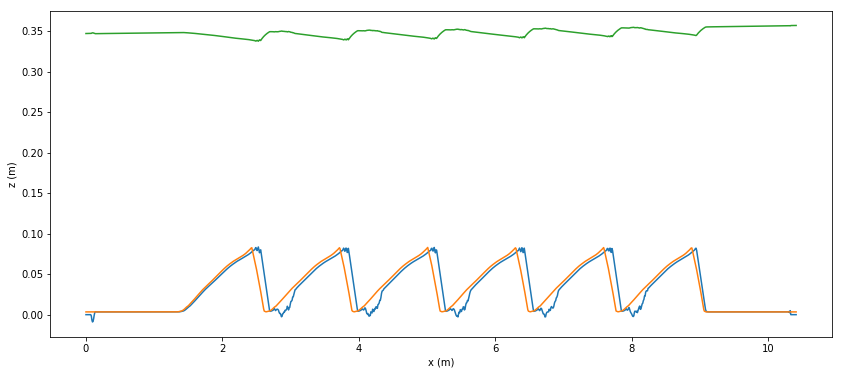

In [191]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*5       # Runtime in seconds
dt = 1                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1


run_name = 'dune_5_q_{0}_h_{1}_dynamic_reattachment_second'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
model.set_scale_factor(.1)
model.use_modifier()
model.use_periodic_reattachment()
zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [192]:
verts = model._verts

In [193]:
np.save('_output/{0}_verts.npy'.format(run_name),verts)

In [194]:
verts2 = np.load('_output/{0}_verts.npy'.format(run_name))

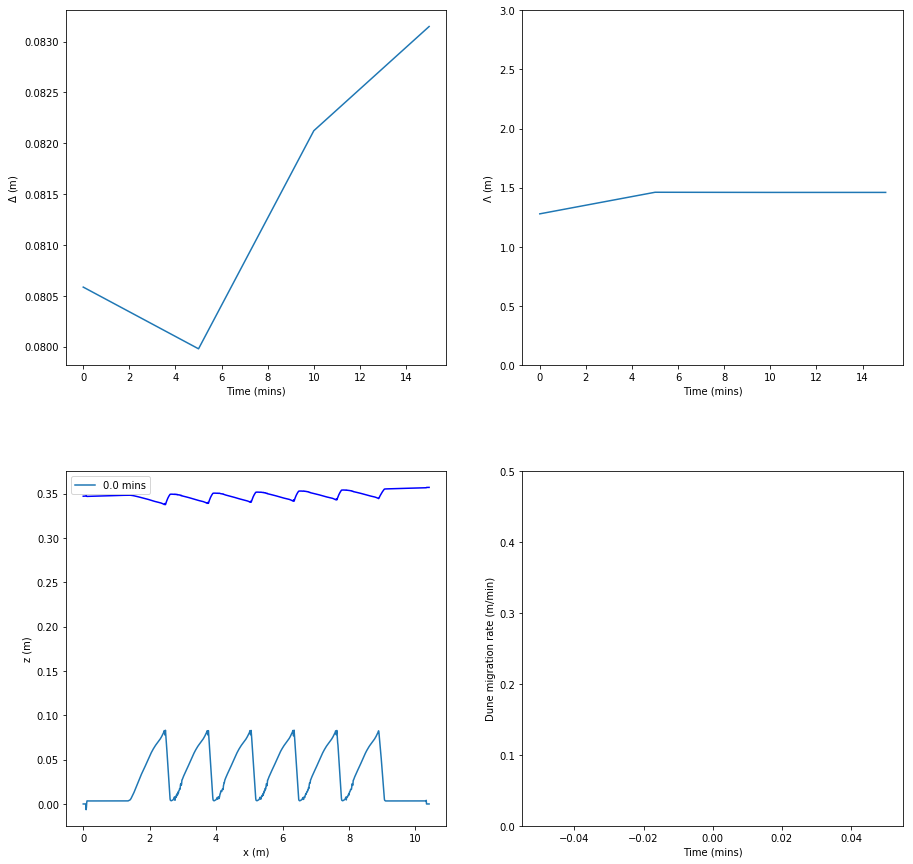

In [195]:
plot_results(verts2)

2019-05-27 01:54:36,245 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2019-05-27 01:54:36,247 INFO CLAW: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x216', '-pix_fmt', 'rgba', '-r', '12.5', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpkd1bo1lp/temp.m4v']


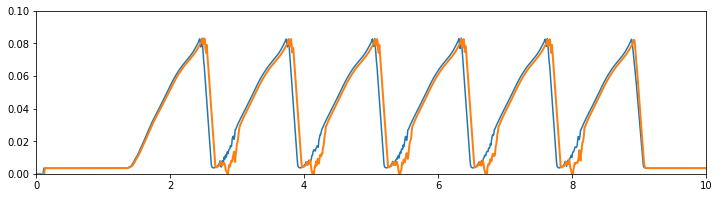

In [198]:
make_animation(verts2)

 Starting simulation....
Number of time steps: 5.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.5754901246148568 - Elevation 0.3482171522577064
Courant number: 204.37937602280803
Time step: 2.0 mins - uavg: 0.5755680778485637 - Elevation 0.34821078164392416
Courant number: 181.15730317267128
Time step: 3.0 mins - uavg: 0.5755905375226528 - Elevation 0.34820710351212647
Courant number: 8.129470312339924
Time step: 4.0 mins - uavg: 0.5756083461413789 - Elevation 0.3482039992214262
Courant number: 7.45144744927713


Text(0, 0.5, 'z (m)')

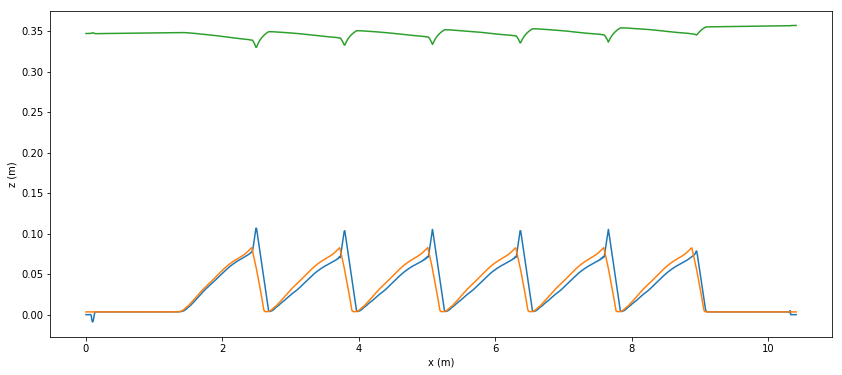

In [199]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*5       # Runtime in seconds
dt = 1                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1


run_name = 'dune_5_q_{0}_h_{1}_dynamic_reattachment_second'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
model.set_scale_factor(.8)
model.use_modifier()
model.use_periodic_reattachment()
zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

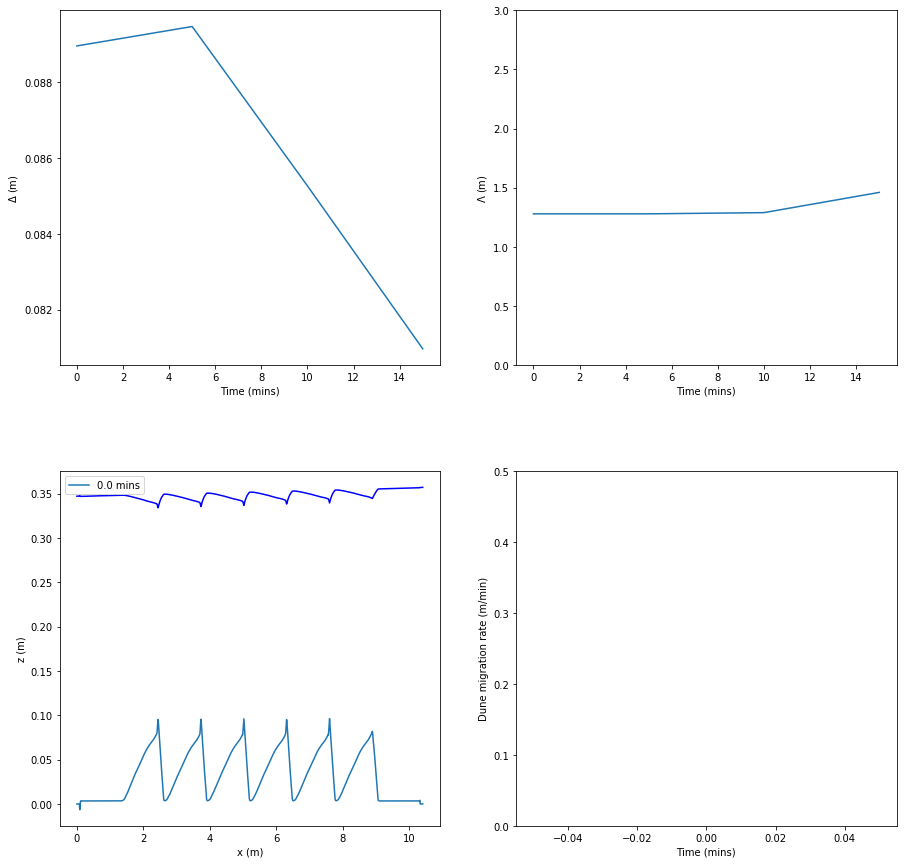

In [201]:
verts2 = np.load('_output/{0}_verts.npy'.format(run_name))
plot_results(verts2)

 Starting simulation....
Number of time steps: 30.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.5752542297397205 - Elevation 0.348233369160596
Courant number: 203.97246882988355
Time step: 2.0 mins - uavg: 0.5750923673720745 - Elevation 0.34824228610590147
Courant number: 61.8763797389993
Time step: 3.0 mins - uavg: 0.5749281787424382 - Elevation 0.34825120637946555
Courant number: 304.5686947503859
Time step: 4.0 mins - uavg: 0.5747681901794464 - Elevation 0.3482598472007612
Courant number: 77.60270807558489
Time step: 5.0 mins - uavg: 0.5746136568549993 - Elevation 0.3482680929903483
Courant number: 62.55166735986309
Time step: 6.0 mins - uavg: 0.5744610813594734 - Elevation 0.34827602290313475
Courant number: 9.999907337973672
Time step: 7.0 mins - uavg: 0.5743179893807298 - Elevation 0.3482834686981792
C

Text(0, 0.5, 'z (m)')

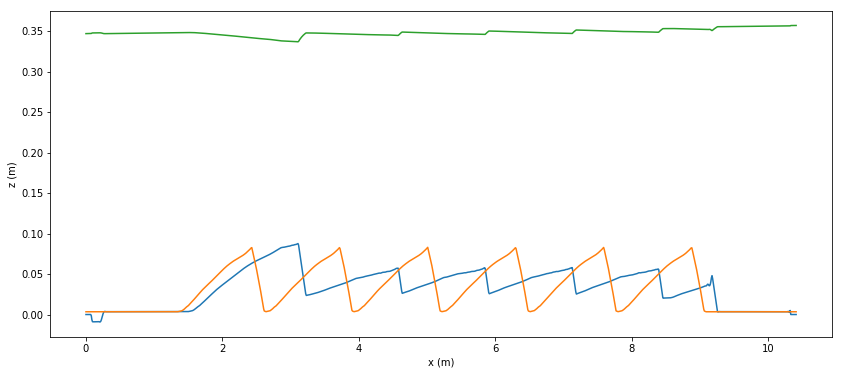

In [205]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*30       # Runtime in seconds
dt = 1                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1


run_name = 'dune_5_q_{0}_h_{1}_dynamic_reattachment_second'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
model.set_scale_factor(1)
model.use_modifier()
model.use_periodic_reattachment()
zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

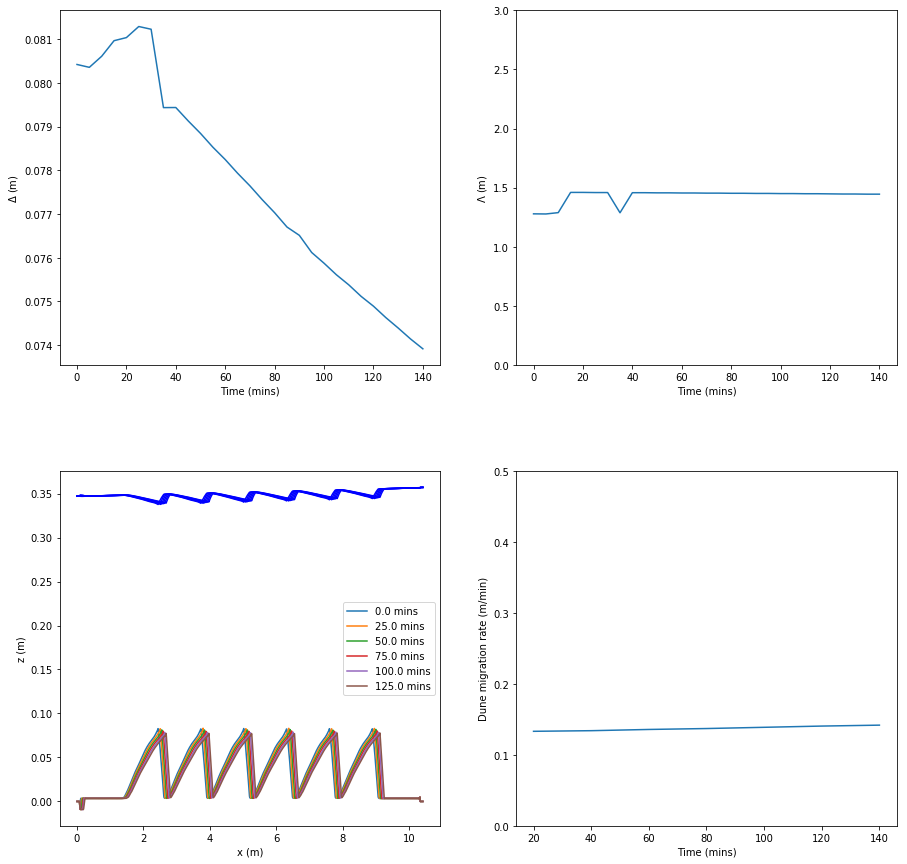

In [209]:
run_name = 'dune_5_q_{0}_h_{1}_dynamic_reattachment_second'.format('32m','357mm')

verts_mod_scal = np.load('_output/{0}_verts.npy'.format(run_name))
plot_results(verts_mod_scal)

# No modification of the bed load

The following is a simple run of the model with no modification of the bedload. 

 Starting simulation....
Number of time steps: 30.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.575207010059975 - Elevation 0.3482375732308524
Courant number: 863.4916857721174
Time step: 2.0 mins - uavg: 0.5752024696428176 - Elevation 0.34823903739282863
Courant number: 42.50130369734734
Time step: 3.0 mins - uavg: 0.5751970482398117 - Elevation 0.34824058538683594
Courant number: 30.589340669515913
Time step: 4.0 mins - uavg: 0.5751910460537165 - Elevation 0.34824221177768494
Courant number: 59.43309284412877
Time step: 5.0 mins - uavg: 0.5751799754130111 - Elevation 0.34824421449334875
Courant number: 6.799001953538888
Time step: 6.0 mins - uavg: 0.5751326802383075 - Elevation 0.34824828491237536
Courant number: 27.134884648673765
Time step: 7.0 mins - uavg: 0.5750787517101544 - Elevation 0.34825252705572

Text(0, 0.5, 'z (m)')

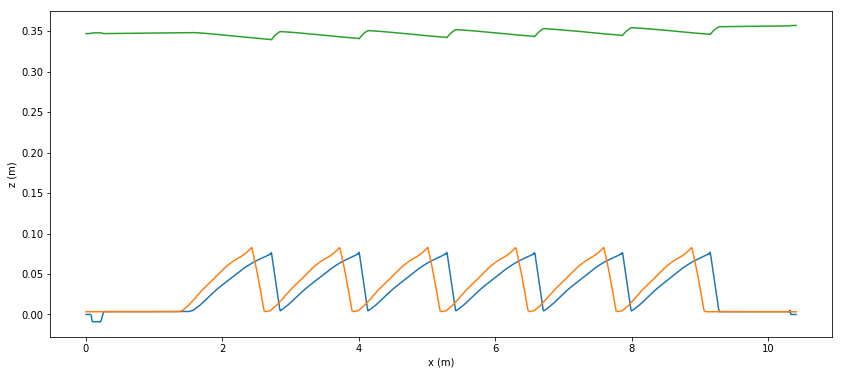

In [207]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*30      # Runtime in seconds
dt = 1                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1


run_name = 'dune_5_q_{0}_h_{1}_dynamic_reattachment_second'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()
zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

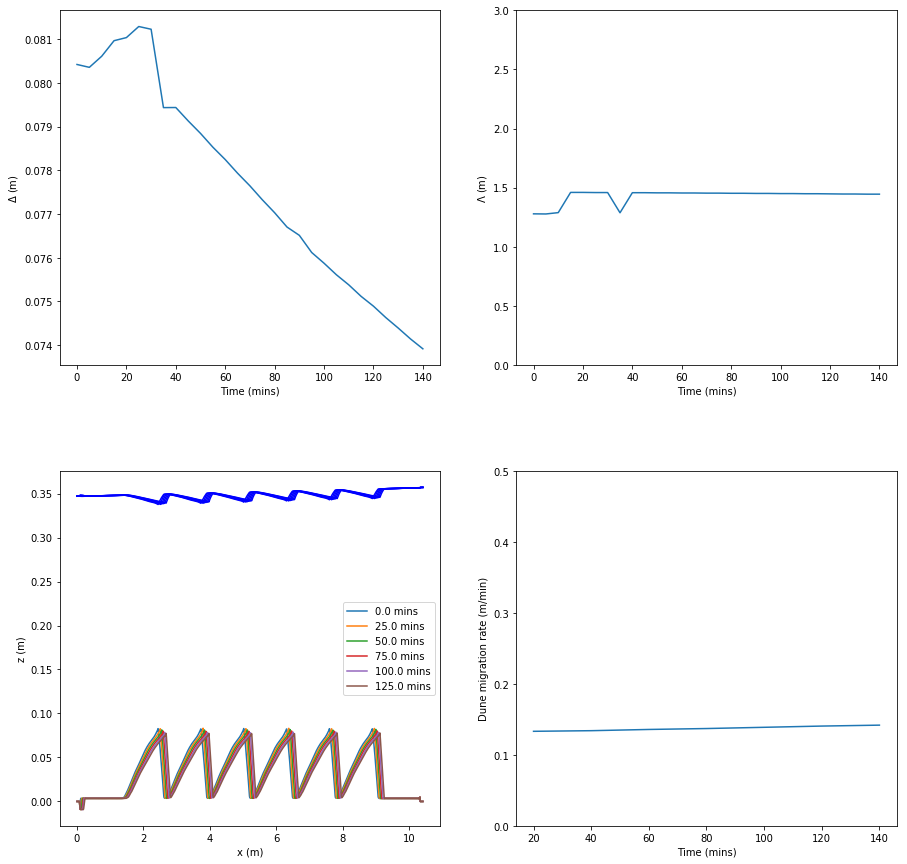

In [208]:
verts_no_mod = np.load('_output/{0}_verts.npy'.format(run_name))
plot_results(verts_no_mod)

## Modifed but no recirculating flow

So this model has qsb = 0 within the reciculation region.

 Starting simulation....
Number of time steps: 30.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.575241238172617 - Elevation 0.348234341432713
Courant number: 80.33369749844385
Time step: 2.0 mins - uavg: 0.5750553870257227 - Elevation 0.34824472870980644
Courant number: 13.445749711786315
Time step: 3.0 mins - uavg: 0.5748707743621521 - Elevation 0.34825486194718225
Courant number: 96.56451331269051
Time step: 4.0 mins - uavg: 0.5746991455736169 - Elevation 0.3482644682754552
Courant number: 15.938817211893472
Time step: 5.0 mins - uavg: 0.574527710273928 - Elevation 0.3482737952189734
Courant number: 44.59254976672297
Time step: 6.0 mins - uavg: 0.5743651632659975 - Elevation 0.3482824720721064
Courant number: 24.33111169161312
Time step: 7.0 mins - uavg: 0.5742094927956141 - Elevation 0.3482906227059047
Co

Text(0, 0.5, 'z (m)')

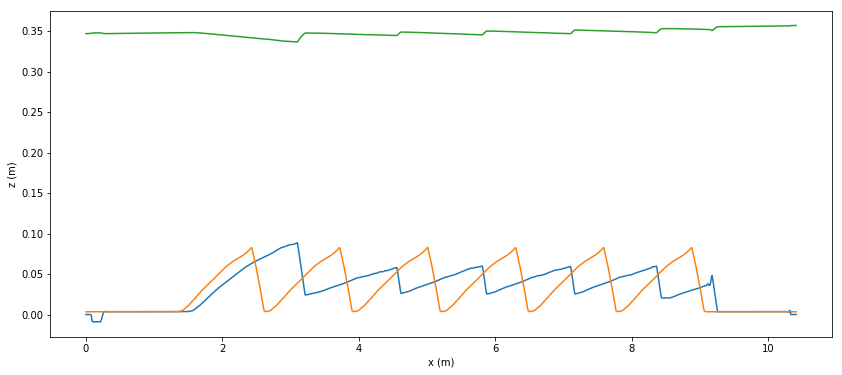

In [211]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*30      # Runtime in seconds
dt = 1                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1


run_name = 'dune_5_q_{0}_h_{1}_no_recirc'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
model.set_scale_factor(1)
model.use_modifier()
model.use_periodic_reattachment()
zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

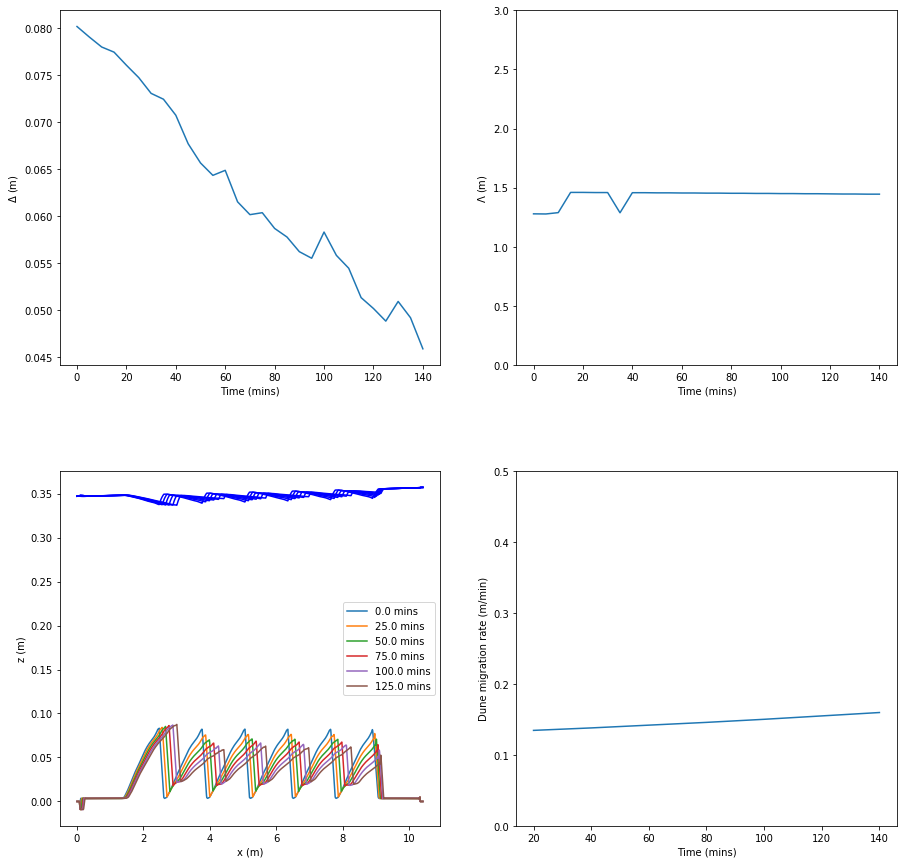

In [212]:
verts_no_qsb = np.load('_output/{0}_verts.npy'.format(run_name))
plot_results(verts_no_qsb)

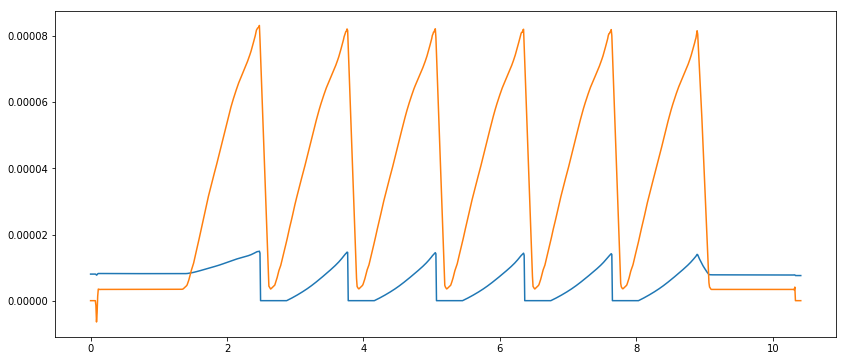

In [226]:
time = 15
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, verts_no_qsb[time,:,5])
plt.plot(x0, verts_no_qsb[time,:,1]/1000)

No reciculation - matched to the 2D flows



 Starting simulation....
Number of time steps: 20.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 0.1 mins - uavg: 0.5752465612989477 - Elevation 0.34823269232363924
Courant number: max 847.3939898549498, mean-0.9401010648146579
Time step: 0.2 mins - uavg: 0.5752586888356247 - Elevation 0.3482327007188324
Courant number: max 3463.268866586903, mean4.363830499996183
Time step: 0.3 mins - uavg: 0.5752745268630622 - Elevation 0.3482318191977632
Courant number: max 449.23966729066143, mean-3.0431821259992238
Time step: 0.4 mins - uavg: 0.5752869456033878 - Elevation 0.3482310624775625
Courant number: max 1812.6217743354516, mean1.290903172991598
Time step: 0.5 mins - uavg: 0.5752962384024549 - Elevation 0.34823037452914124
Courant number: max 798.7378800836262, mean-0.6635966548611127
Time step: 0.6 mins - uavg: 0.575302854738684 - 

Text(0, 0.5, 'z (m)')

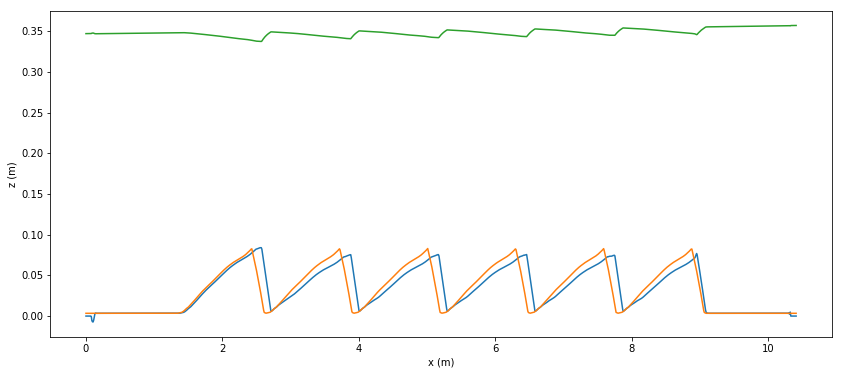

In [233]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*10     # Runtime in seconds
dt = 0.5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*0.1


run_name = 'dune_5_q_{0}_h_{1}_no_recirc_2dmatched'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = sdmodels.EulerWenoModel()
#morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
model.set_scale_factor(1)
model.use_modifier()
model.use_periodic_reattachment()
zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

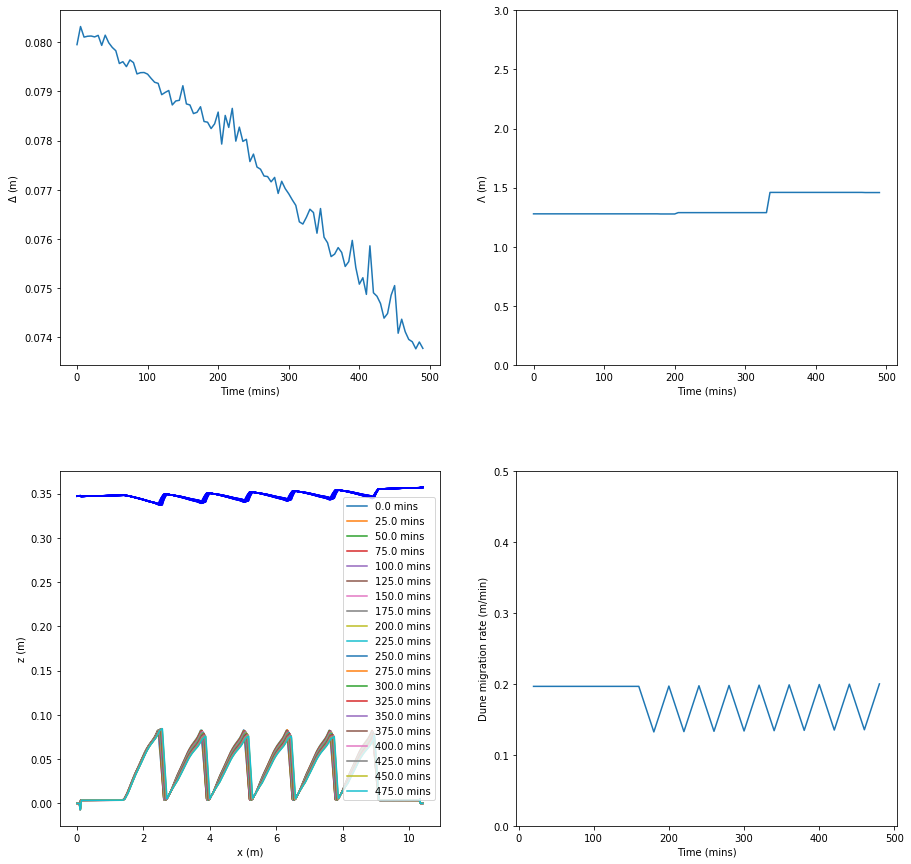

In [234]:
verts_no_qsb = np.load('_output/{0}_verts.npy'.format(run_name))
plot_results(verts_no_qsb)

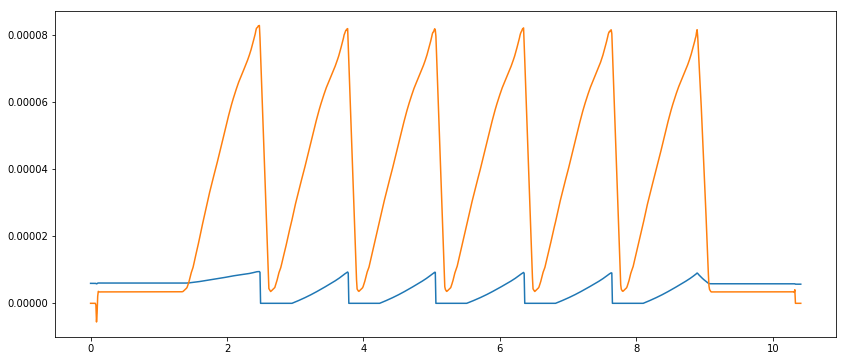

In [235]:
time = 15
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, verts_no_qsb[time,:,5])
plt.plot(x0, verts_no_qsb[time,:,1]/1000)

## Plain 2D shallow - no modification

#match 2d
a = 0.000016
b = 1.5


 Starting simulation....
Number of time steps: 15.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 0.5 mins - uavg: 0.5752152832965999 - Elevation 0.34823679203235536
Courant number: max 283.8589956925555, mean-5.363439850398394
Time step: 1.0 mins - uavg: 0.5752138411107837 - Elevation 0.3482378268261171
Courant number: max 82.36487516573678, mean0.15065228889533994
Time step: 1.5 mins - uavg: 0.5752125150717098 - Elevation 0.34823863201364497
Courant number: max 201.59275860063616, mean-1.7864812445914944
Time step: 2.0 mins - uavg: 0.5752106621665105 - Elevation 0.3482395052366608
Courant number: max 176.77432041613565, mean0.5992136724162331
Time step: 2.5 mins - uavg: 0.5752060627708706 - Elevation 0.34824053109408387
Courant number: max 27.792760381308902, mean0.06368755565496109
Time step: 3.0 mins - uavg: 0.57518467861155

Text(0, 0.5, 'z (m)')

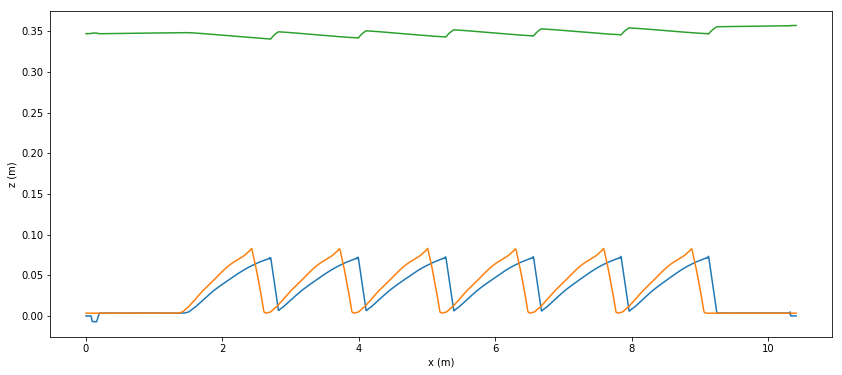

In [245]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*30     # Runtime in seconds
dt = 2.0                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*0.5


run_name = 'dune_5_q_{0}_h_{1}_no_recirc_2dmatched'.format('32m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = sdmodels.EulerWenoModel()
#morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

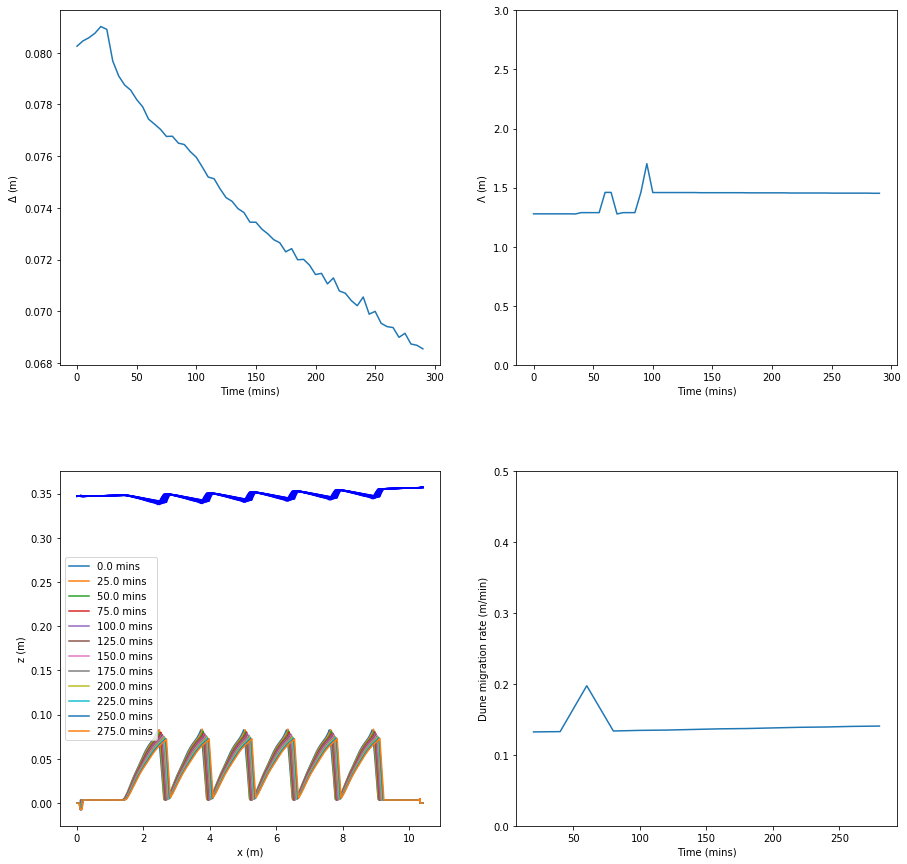

In [246]:
verts_no_qsb = np.load('_output/{0}_verts.npy'.format(run_name))
plot_results(verts_no_qsb)

In [247]:
## 20 cm flow case - 2D

#match 2d
a = 0.000016
b = 1.5
        

 Starting simulation....
Number of time steps: 15.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 0.5 mins - uavg: 0.41262387899560243 - Elevation 0.22918273833405645
Courant number: max 379.29799865618776, mean-2.39942090208156
Time step: 1.0 mins - uavg: 0.41258348169119274 - Elevation 0.2291924250722012
Courant number: max 223.38642073695218, mean-0.49960961566794604
Time step: 1.5 mins - uavg: 0.412575116691945 - Elevation 0.22919348751892982
Courant number: max 113.37894250362488, mean-0.14634787259205087
Time step: 2.0 mins - uavg: 0.4125634767950342 - Elevation 0.22919459711657883
Courant number: max 45.59928940696383, mean-0.19068703404609533
Time step: 2.5 mins - uavg: 0.4125478105136901 - Elevation 0.2291959647178903
Courant number: max 249.19395095043726, mean-0.012887173677965153
Time step: 3.0 mins - uavg: 0.4125291

Text(0, 0.5, 'z (m)')

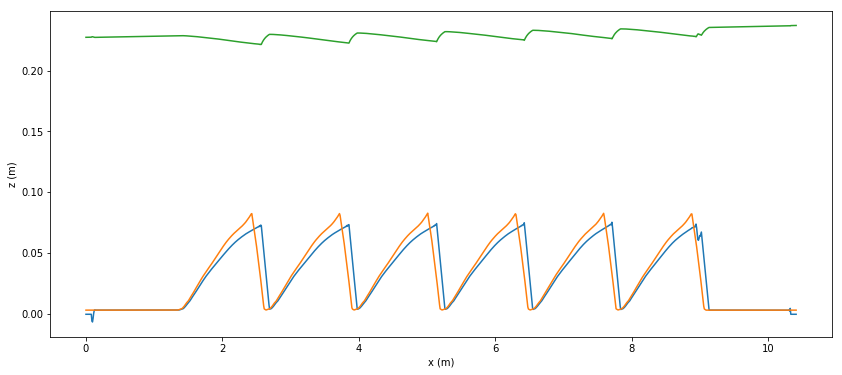

In [248]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*30     # Runtime in seconds
dt = 2.0                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*0.5


run_name = 'dune_5_q_{0}_h_{1}_no_recirc_2dmatched'.format('20m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = sdmodels.EulerWenoModel()
#morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

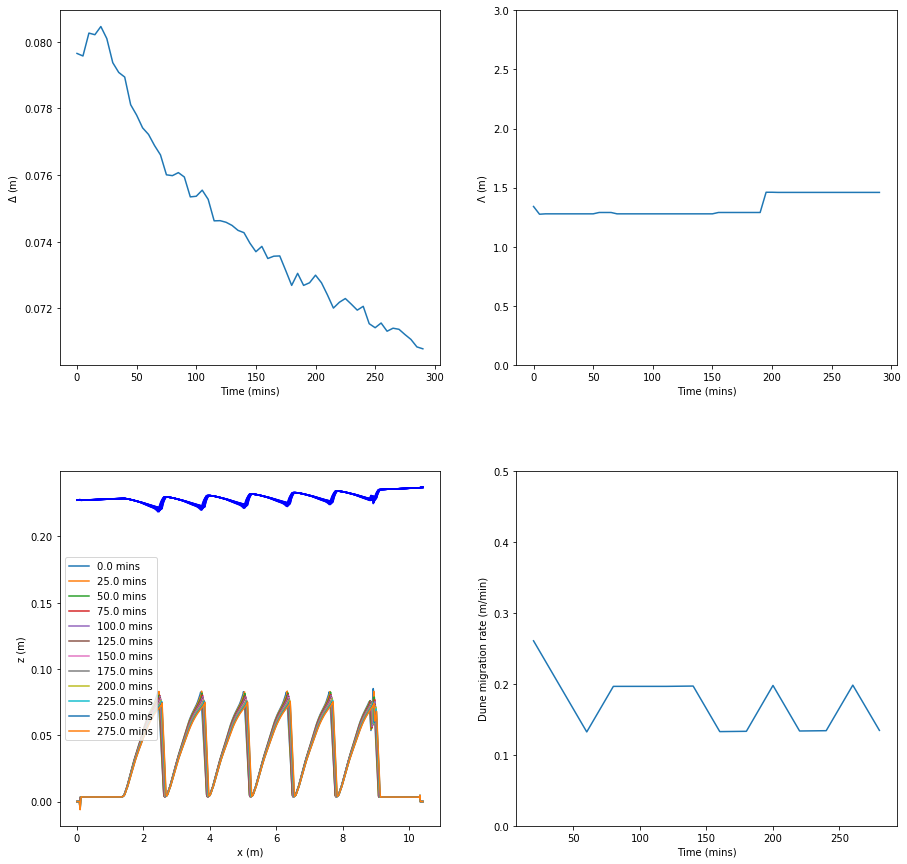

In [249]:
verts_20 = np.load('_output/{0}_verts.npy'.format(run_name))
plot_results(verts_20)

## Paarlberg 2009 model approach

Here we use a parameterized model by Paarlberg which shuts down 

 Starting simulation....
Number of time steps: 57.68333333333333 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 6.5 mins - uavg: 0.5751621314668894 - Elevation 0.3482447517076614
Courant number: max 60.830758330466224, mean0.09994822141204071
Time step: 13.0 mins - uavg: 0.5749757778047114 - Elevation 0.3482604312083522
Courant number: max 544.8445069895939, mean0.4636280380770361
Time step: 19.5 mins - uavg: 0.5748890165203484 - Elevation 0.34826992424330977
Courant number: max 2.301082154929699, mean0.005783158971912266
Time step: 26.0 mins - uavg: 0.574759130088781 - Elevation 0.348281935460756
Courant number: max 21.58879216621878, mean0.02356366250914123


Text(0, 0.5, 'z (m)')

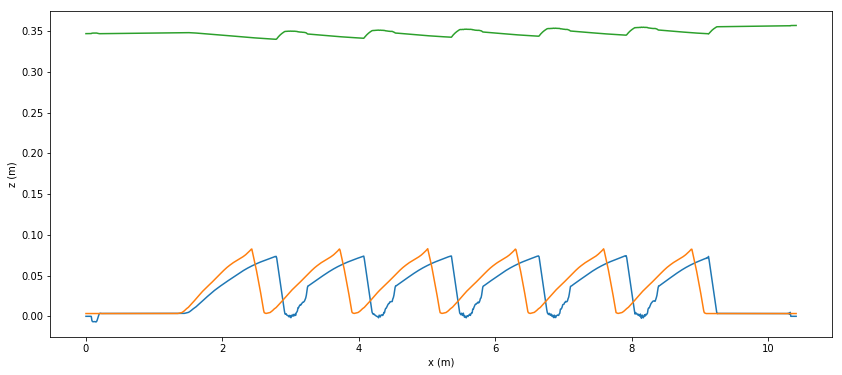

In [11]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*30     # Runtime in seconds
dt = 0.52                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*0.5


run_name = 'dune_5_q_{0}_h_{1}_parrlberg'.format('20m','357mm')

model = sdmodels.ModifiedShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = sdmodels.EulerWenoModel()
#morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
model.set_scale_factor(1)
model.use_modifier()
model.use_periodic_reattachment()

zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

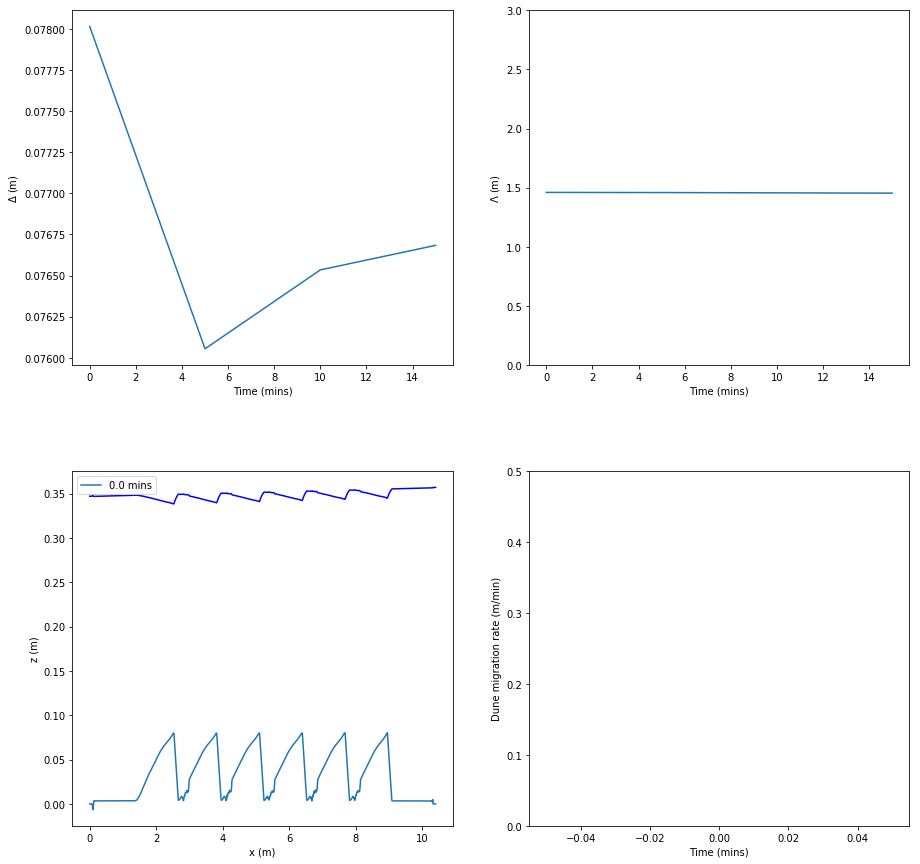

In [12]:
run_name = 'dune_5_q_{0}_h_{1}_parrlberg'.format('20m','357mm')
verts_paarl = np.load('_output/{0}_verts.npy'.format(run_name))
plot_results(verts_paarl)

2019-05-28 20:02:16,884 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2019-05-28 20:02:16,886 INFO CLAW: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x216', '-pix_fmt', 'rgba', '-r', '12.5', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpsu4ulfxl/temp.m4v']


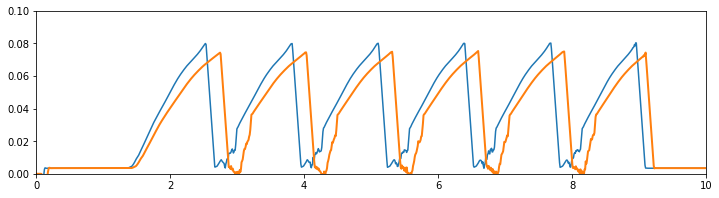

In [13]:
make_animation(verts_paarl)

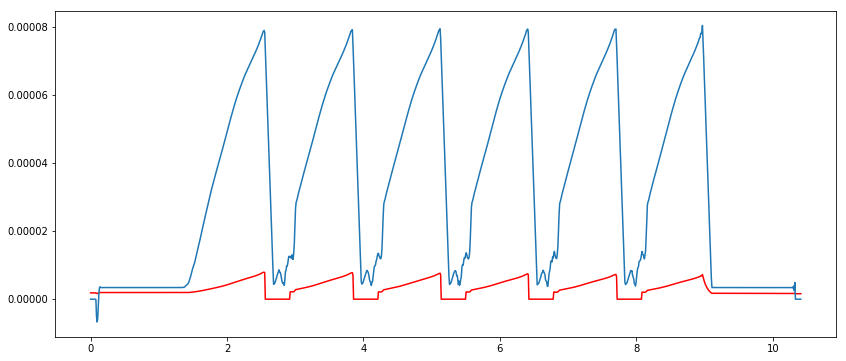

In [10]:
time = 15
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, verts_paarl[time,:,5],'r')
plt.plot(x0, verts_paarl[time,:,1]/1000)

2019-05-30 14:10:22,161 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2019-05-30 14:10:22,163 INFO CLAW: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x216', '-pix_fmt', 'rgba', '-r', '12.5', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpjvcdw6mw/temp.m4v']


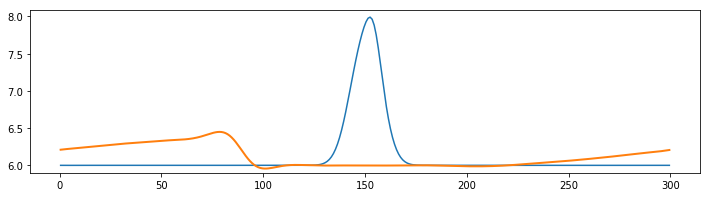

In [8]:
verts2 = np.load('_output/{0}_verts.npy'.format('gauss_maccormack_long'))

make_animation(verts2)